In [1]:
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pyproj
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

# OSGB is also called "OSGB 1936 / British National Grid -- United
# Kingdom Ordnance Survey".  OSGB is used in many UK electricity
# system maps, and is used by the UK Met Office UKV model.  OSGB is a
# Transverse Mercator projection, using 'easting' and 'northing'
# coordinates which are in meters.  See https: #epsg.io/27700
OSGB_EPSG = 27700

# WGS84 is short for "World Geodetic System 1984", used in GPS. Uses
# latitude and longitude.
WGS84_EPSG = 4326


plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['figure.facecolor'] = 'white'

PV_PATH = Path("/mnt/storage_b/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/PV/Passiv/ocf_formatted/v0")
PV_DATA_PATH = PV_PATH / "passiv.netcdf"
PV_METADATA_PATH = PV_PATH / "system_metadata_OCF_ONLY.csv"

NWP_ZARR_PATH = Path("/mnt/storage_ssd_8tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/NWP/UK_Met_Office/UKV/zarr/UKV_intermediate_version_3.zarr")

## Open and prepare PV data

In [2]:
pv_data = xr.open_dataset(PV_DATA_PATH)
pv_metadata = (
    pd.read_csv(PV_METADATA_PATH, index_col="system_id")
    .drop(columns=["Unnamed: 0", "ss_id", "llsoacd"])
)

In [3]:
pv_metadata = gpd.GeoDataFrame(
    pv_metadata,
    geometry=gpd.points_from_xy(pv_metadata.longitude, pv_metadata.latitude, crs=WGS84_EPSG)
)

In [4]:
all_pv_system_ids = [
    int(system_id) for system_id in list(pv_data.variables.keys())
    if system_id != "datetime"
]

# Remove "day behind" PV systems from metadata:

all_pv_system_ids = pv_metadata.index.intersection(all_pv_system_ids)
pv_metadata = pv_metadata.loc[all_pv_system_ids]

In [5]:
# 1 has good data but very little shading (maybe just a tiny bit in the late-afternoon?)
# 3 has good data, and I think has more shading that 1 (in the morning)
# 5 has most shading so far
# 7 has no shading
# 8 has lots of shading
# 12 has no shading
# 13 has lots of shading!

pv_system_id = all_pv_system_ids[13]
pv_system_id

2766

In [6]:
# Find the nearest N PV systems to pv_system_id
point = pv_metadata.loc[pv_system_id].geometry
pv_metadata["distance"] = pv_metadata.apply(lambda row: point.distance(row.geometry), axis=1)

In [7]:
nearby_pv_systems = pv_metadata.sort_values("distance").iloc[1:11]
nearby_pv_systems

,orientation,tilt,kwp,operational_at,latitude,longitude,geometry,distance
system_id,,,,,,,,
17465,180.0,55.0,4.00,2015-07-16,55.891193,-4.890903,POINT (-4.89090 55.89119),0.089226
3872,135.0,40.0,3.99,2012-02-20,55.890190,-4.897210,POINT (-4.89721 55.89019),0.090607
10512,250.0,35.0,2.50,2014-06-03,55.953359,-4.819659,POINT (-4.81966 55.95336),0.152017
11828,208.0,33.0,2.50,2014-09-26,55.654983,-4.808111,POINT (-4.80811 55.65498),0.161074
7390,180.0,35.0,3.06,2013-04-02,55.940140,-4.769610,POINT (-4.76961 55.94014),0.161458
11895,170.0,36.0,2.00,2014-11-13,55.958428,-4.794455,POINT (-4.79445 55.95843),0.165352
13500,168.0,36.0,2.50,2014-12-03,55.703895,-4.730323,POINT (-4.73032 55.70390),0.166582
7700,146.0,30.0,2.50,2013-08-08,55.703009,-4.727332,POINT (-4.72733 55.70301),0.169482
7066,135.0,30.0,3.92,2012-12-15,55.651491,-4.790962,POINT (-4.79096 55.65149),0.170676


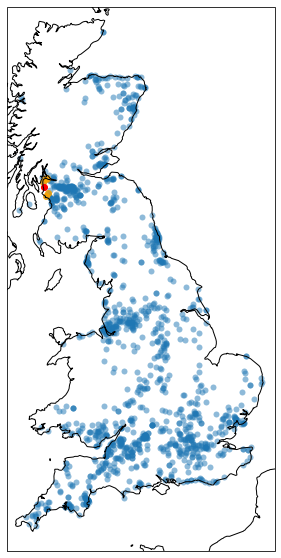

In [8]:
# Plot all PV systems, and PV system of interest, and nearby PV systems
ax = plt.axes(projection=ccrs.PlateCarree())
pv_metadata.plot(ax=ax, alpha=0.5, linewidth=0)
nearby_pv_systems.plot(ax=ax, alpha=0.5, color="orange")
ax.scatter(
    *pv_metadata.loc[pv_system_id][["longitude", "latitude"]], 
    color="red")
ax.coastlines();

In [9]:
pv_data_for_single_system = pv_data[str(pv_system_id)].to_pandas().dropna()
pv_data_for_nearby_systems = pd.concat(
    [
        pv_data[str(nearby_pv_system_id)].to_pandas().dropna().rename(nearby_pv_system_id)
        for nearby_pv_system_id in nearby_pv_systems.index
    ],
    axis="columns"
    )

In [10]:
pv_data_for_single_system.index[0], pv_data_for_single_system.index[-1]

(Timestamp('2018-01-01 06:05:00'), Timestamp('2021-10-27 23:55:00'))

In [11]:
pv_data_for_nearby_systems

,17465,3872,10512,11828,7390,11895,13500,7700,7066,11174
datetime,,,,,,,,,,
2018-01-01 06:05:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2018-01-01 06:10:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2018-01-01 06:15:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2018-01-01 06:20:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2018-01-01 06:25:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-10-27 23:35:00,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN
2021-10-27 23:40:00,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN
2021-10-27 23:45:00,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN


/tmp/ipykernel_32362/204571188.py:10: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  pv_data_for_nearby_systems.loc[DATE].rolling("60min").mean() / pv_data_for_nearby_systems[DATE].max(),


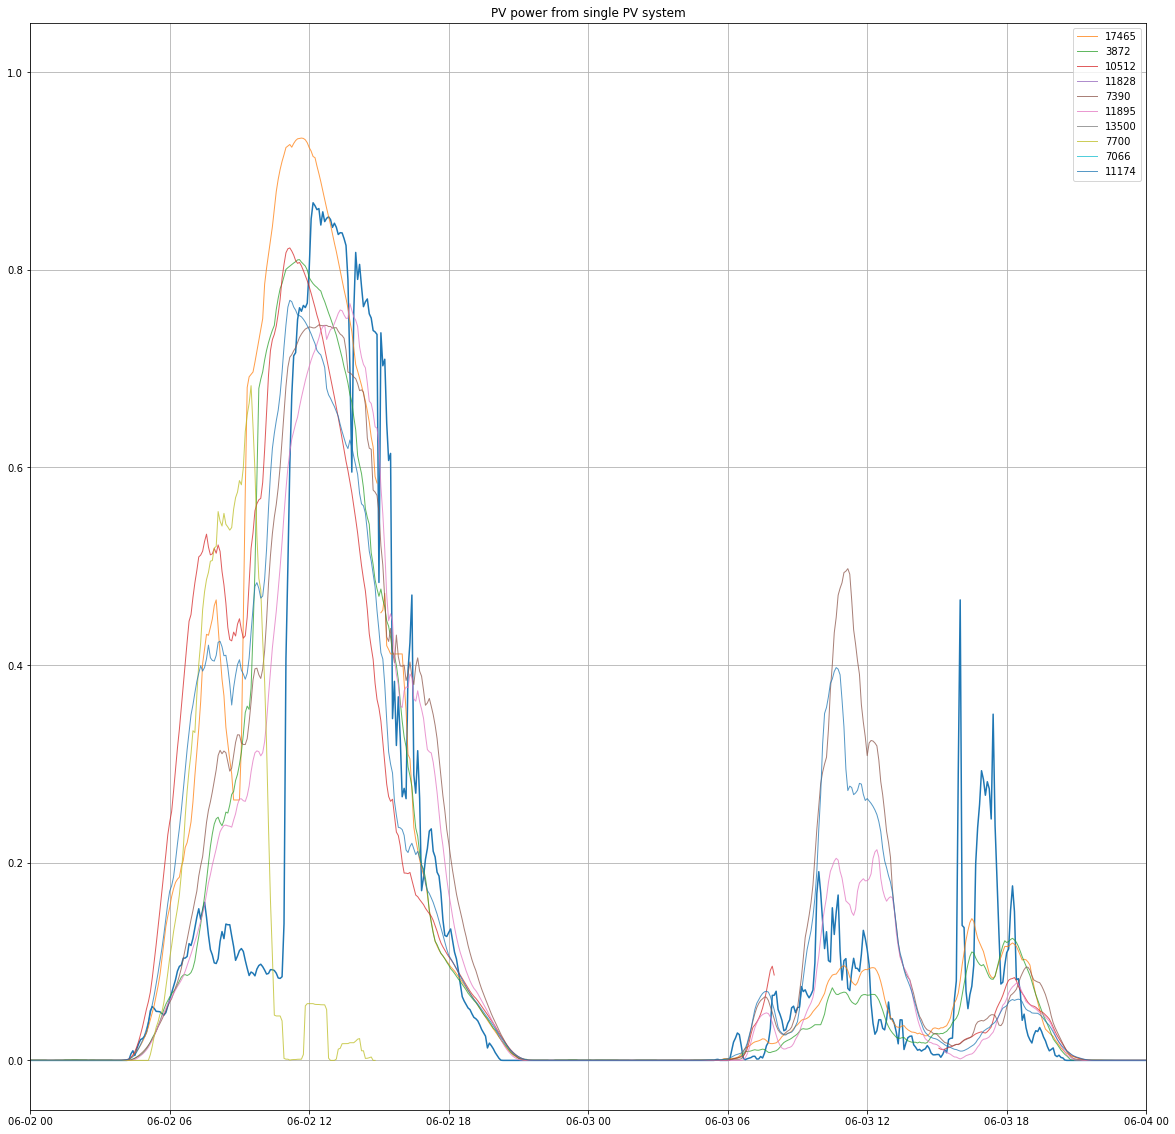

In [12]:
DATE = "2021-06"

fig, ax = plt.subplots(figsize=(20, 20))

ax.plot(pv_data_for_single_system[DATE] / pv_data_for_single_system[DATE].max())
ax.set_title("PV power from single PV system")


ax.plot(
    pv_data_for_nearby_systems.loc[DATE].rolling("60min").mean() / pv_data_for_nearby_systems[DATE].max(), 
    linewidth=1, 
    alpha=0.75,
    label=[str(pv_id) for pv_id in pv_data_for_nearby_systems.columns],
)
ax.legend()

ax.set_xlim(
    mdates.datestr2num("2021-06-02"),
    mdates.datestr2num("2021-06-04")
)
ax.grid();

In [13]:
data_for_plot = pv_data_for_single_system[pv_data_for_single_system.index.month == 7].to_frame("power")
data_for_plot["hour_of_day"] = data_for_plot.index.hour + (data_for_plot.index.minute / 60)

In [14]:
data_for_plot_pivotted = data_for_plot.pivot_table(
    index="hour_of_day",
    columns=data_for_plot.index.date,
    values="power",
)

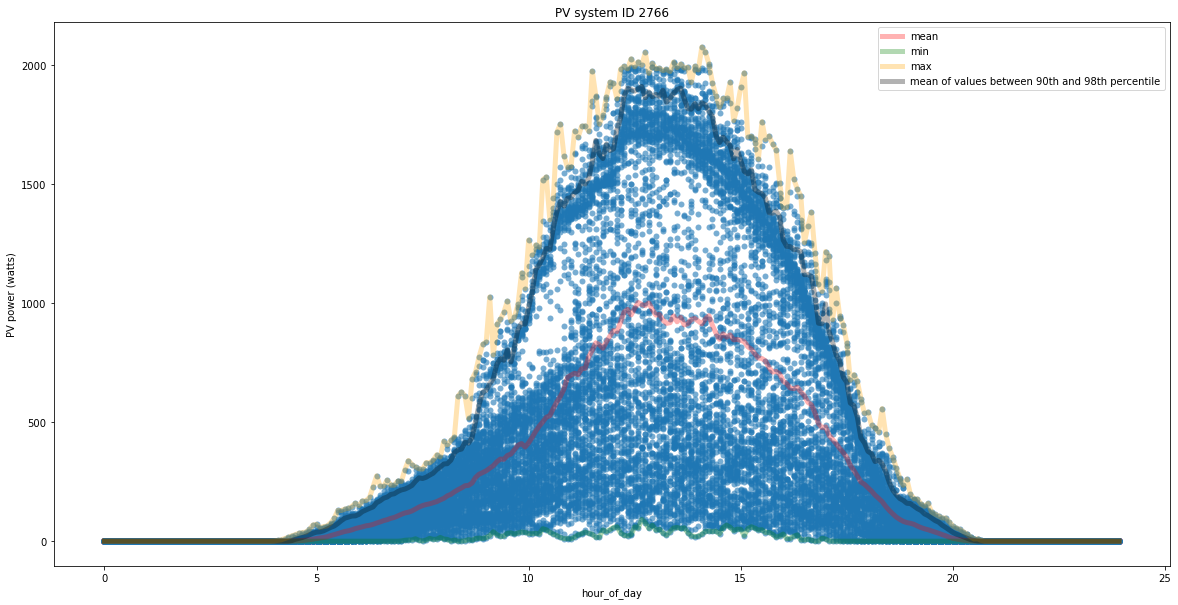

In [15]:
fig, ax = plt.subplots()
ax.scatter(
    x=data_for_plot["hour_of_day"],
    y=data_for_plot["power"],
    alpha=0.6,
    linewidths=0
)
line_plot_kwargs = dict(ax=ax, linewidth=5, alpha=0.3)
data_for_plot_pivotted.mean(axis="columns").plot(color="red", label="mean", **line_plot_kwargs)
data_for_plot_pivotted.min(axis="columns").plot(color="green", label="min", **line_plot_kwargs)
data_for_plot_pivotted.max(axis="columns").plot(color="orange", label="max", **line_plot_kwargs)

data_for_plot_pivotted[
    data_for_plot_pivotted.ge(data_for_plot_pivotted.quantile(q=0.90, axis="columns"), axis="index") &
    data_for_plot_pivotted.le(data_for_plot_pivotted.quantile(q=0.98, axis="columns"), axis="index")
].mean(axis="columns").plot(color="black", label="mean of values between 90th and 98th percentile", **line_plot_kwargs)

ax.set_title(f"PV system ID {pv_system_id}")
ax.set_ylabel("PV power (watts)")

ax.legend();

## pvlib

See [this StackOverflow answer for how to use pvlib for "generic" PV systems](https://stackoverflow.com/a/57169613/732596).

In [16]:
from pvlib import pvsystem, location, modelchain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

In [17]:
metadata_for_pv_system = pv_metadata.loc[pv_system_id]
metadata_for_pv_system

orientation                                              185.0
tilt                                                      30.0
kwp                                                       2.25
operational_at                                      2011-09-16
latitude                                             55.807096
longitude                                            -4.861087
geometry          POINT (-4.861086566736806 55.80709595696567)
distance                                                   0.0
Name: 2766, dtype: object

In [18]:
power_watts = max(
    pv_data_for_single_system.max(),
    metadata_for_pv_system.kwp * 1000,
)

module_parameters = dict(
    pdc0=power_watts,
    gamma_pdc=-0.004,  # from https://pvlib-python.readthedocs.io/en/stable/pvsystem.html
)

inverter_parameters = dict(
    pdc0=power_watts,
    # eta_inv_norm=0.96,  # from https: #pvlib-python.readthedocs.io/en/stable/pvsystem.html
)

In [19]:
power_watts

2250.0

In [20]:
pv_system = pvsystem.PVSystem(
    surface_tilt=metadata_for_pv_system["tilt"],
    surface_azimuth=metadata_for_pv_system["orientation"],
    module_parameters=module_parameters,
    inverter_parameters=inverter_parameters,
    temperature_model_parameters=TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass'] # from: https://pvlib-python.readthedocs.io/en/stable/forecasts.html#pv-power-forecast
)
pv_system

PVSystem:
  name: None
  Array:
    name: None
    mount: FixedMount(surface_tilt=30.0, surface_azimuth=185.0, racking_model=None, module_height=None)
    module: None
    albedo: 0.25
    module_type: None
    temperature_model_parameters: {'a': -3.47, 'b': -0.0594, 'deltaT': 3}
    strings: 1
    modules_per_string: 1
  inverter: None

In [21]:
pv_location = location.Location(
    latitude=metadata_for_pv_system.latitude,
    longitude=metadata_for_pv_system.longitude,
    tz="Europe/London",
)
pv_location

Location: 
  name: None
  latitude: 55.80709595696567
  longitude: -4.861086566736806
  altitude: 0
  tz: Europe/London

In [22]:
model_chain = modelchain.ModelChain(
    system=pv_system,
    location=pv_location,
    dc_model="pvwatts",
    aoi_model="no_loss",
    spectral_model="no_loss",
)

In [23]:
pv_data_to_forecast = pv_data_for_single_system["2021-06"]

clearsky = pv_location.get_clearsky(times=pv_data_to_forecast.index)

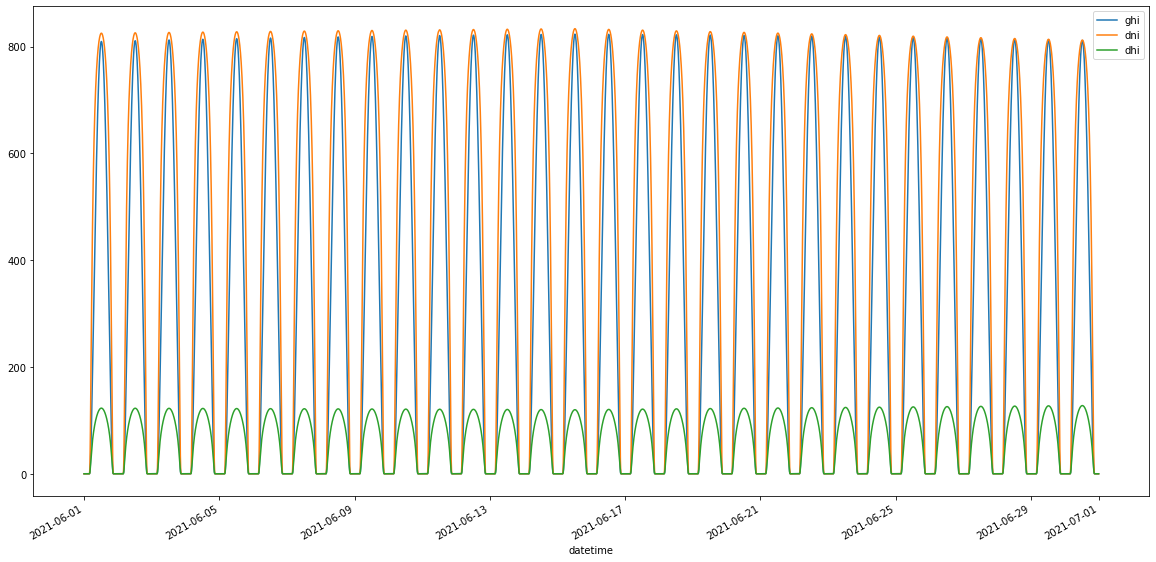

In [24]:
clearsky.plot();

In [25]:
model_chain.run_model(weather=clearsky)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: pvwatts_dc
  ac_model: pvwatts_inverter
  aoi_model: no_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

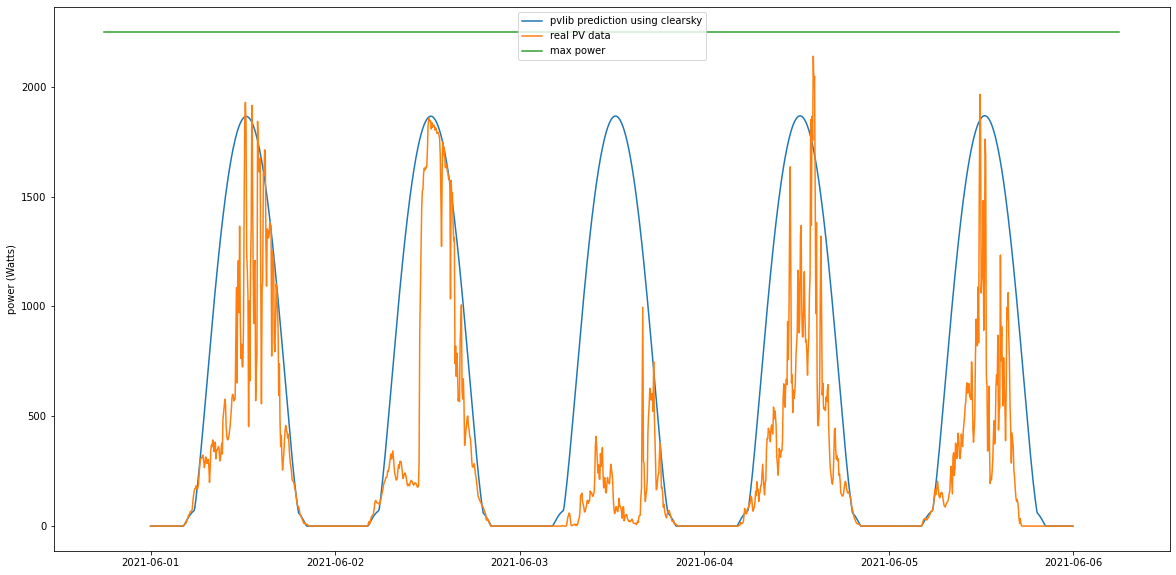

In [26]:
fig, ax = plt.subplots()
DATE = slice("2021-06-01", "2021-06-05")
ax.plot(model_chain.results.ac[DATE], label="pvlib prediction using clearsky")
ax.plot(pv_data_to_forecast[DATE], label="real PV data")
ax.plot(ax.get_xlim(), (power_watts, power_watts), label="max power")
ax.legend()
ax.set_ylabel("power (Watts)");

## Open and prepare NWP data

In [27]:
lat_lon_to_osgb = pyproj.Transformer.from_crs(crs_from=WGS84_EPSG, crs_to=OSGB_EPSG).transform

In [28]:
pv_x_location_osgb, pv_y_location_osgb = lat_lon_to_osgb(
    metadata_for_pv_system.latitude,
    metadata_for_pv_system.longitude,
)

In [29]:
nwp = xr.open_dataset(NWP_ZARR_PATH, engine="zarr", mode="r")
nwp

<xarray.Dataset>
Dimensions:    (variable: 17, init_time: 5319, step: 37, y: 704, x: 548)
Coordinates:
  * init_time  (init_time) datetime64[ns] 2020-01-01 ... 2021-11-08T15:00:00
  * step       (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * variable   (variable) <U6 'cdcb' 'lcc' 'mcc' ... 'wdir10' 'prmsl' 'prate'
  * x          (x) int64 -239000 -237000 -235000 ... 851000 853000 855000
  * y          (y) int64 1223000 1221000 1219000 ... -179000 -181000 -183000
Data variables:
    UKV        (variable, init_time, step, y, x) float32 ...

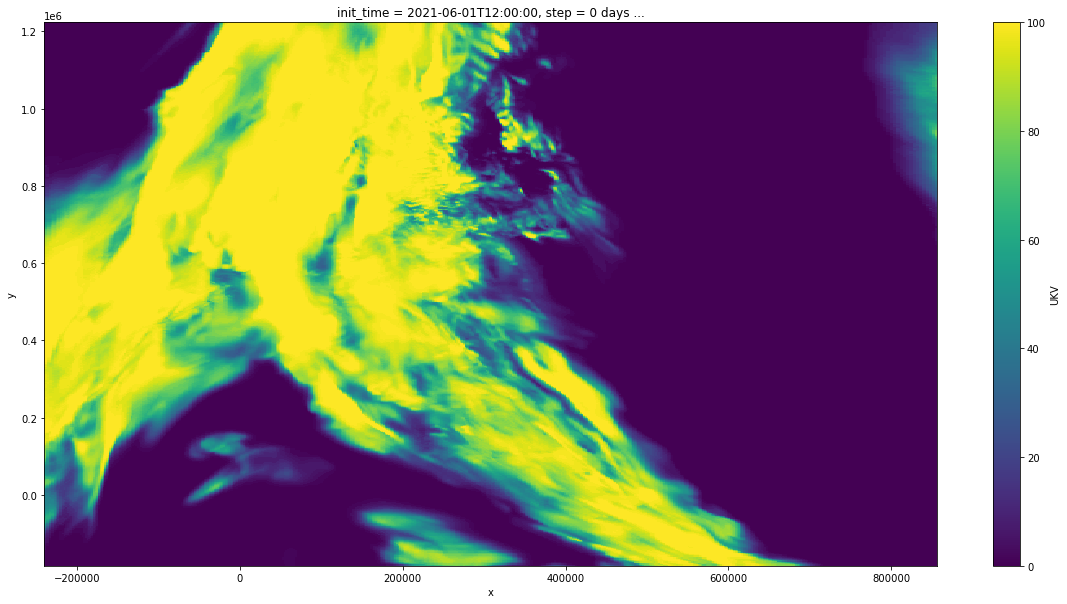

In [30]:
nwp["UKV"].sel(init_time="2021-06-01 12:00", variable="hcc", step=np.timedelta64(0)).plot();

In [31]:
init_times = pv_data_to_forecast.index.floor("3H").unique()

nwp_selected = nwp["UKV"].sel(
    x=pv_x_location_osgb,
    y=pv_y_location_osgb,
    method="nearest",    
).sel(
    init_time=init_times,
    step=slice(
        np.timedelta64(0, "h"), 
        np.timedelta64(6, "h")
        ),
)

In [32]:
# Find unique values

nwp_df = nwp_selected.stack(target_time=("init_time", "step")).T.to_pandas().reset_index()

In [33]:
nwp_df["target_time"] = nwp_df["init_time"] + nwp_df["step"]
nwp_df = nwp_df.sort_values(["target_time", "init_time", "step"]).drop_duplicates(subset="target_time", keep="first")
nwp_df = nwp_df.drop(columns=["init_time", "step"]).set_index("target_time")

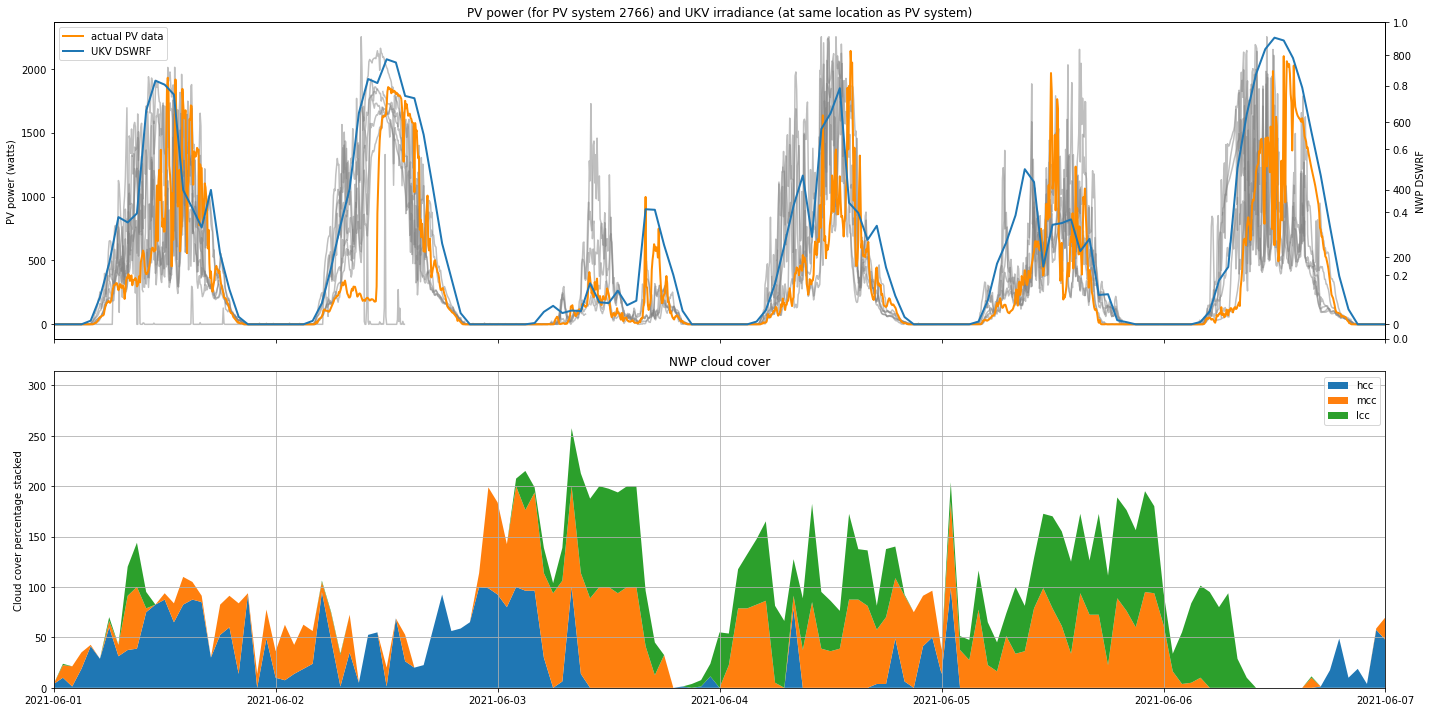

In [34]:
fig, axes = plt.subplots(nrows=2, sharex=True)

ax = axes[0]
ax.plot(
    (
        pv_data_for_nearby_systems.loc[pv_data_to_forecast.index] / 
        pv_data_for_nearby_systems.loc[pv_data_to_forecast.index].max()
        ) * power_watts,
    color="grey",
    alpha=0.5,
)
line1, = ax.plot(pv_data_to_forecast, label="actual PV data", linewidth=2, alpha=1, color="darkorange")
ax.set_ylabel("PV power (watts)")
ax2 = ax.twinx()
line2, = ax2.plot(nwp_df["dswrf"], label="UKV DSWRF", linewidth=2)
ax2.set_ylabel("NWP DSWRF")
ax3 = ax.twinx()
ax.legend(handles=[line1, line2])
ax.set_title(f"PV power (for PV system {pv_system_id}) and UKV irradiance (at same location as PV system)")
ax.set_xlim(
    mdates.datestr2num("2021-06-01"),
    mdates.datestr2num("2021-06-07")
)

ax = axes[1]
CLOUD_VAR_NAMES = ["hcc", "mcc", "lcc"]
ax.stackplot(
    nwp_df.index,
    *[nwp_df[col_name].values[np.newaxis, :] for col_name in CLOUD_VAR_NAMES],
    labels=CLOUD_VAR_NAMES,
)
ax.legend()
ax.set_title("NWP cloud cover")
ax.set_ylabel("Cloud cover percentage stacked")
ax.grid()

fig.tight_layout()

In [35]:
# Use give NWP to pvlib:
# First step, compute GHI, DNI and DHI from cloud cover, as per
# https: #pvlib-python.readthedocs.io/en/stable/forecasts.html#cloud-cover-and-radiation
from pvlib.irradiance import disc

total_cloud_cover = nwp_df[["lcc", "mcc", "hcc"]].max(axis="columns") / 100
total_cloud_cover = total_cloud_cover.resample("5T").interpolate(method="linear", limit=12)
solpos = pv_location.get_solarposition(total_cloud_cover.index)
# OFFSET and cloud cover in decimal units here
# larson et. al. use OFFSET = 0.35
OFFSET = 0.35
#ghi = (OFFSET + (1 - OFFSET) * (1 - total_cloud_cover)) * clearsky.ghi
ghi = nwp_df["dswrf"].resample("5T").interpolate(method="linear", limit=12)
dni = disc(ghi, solpos['zenith'], total_cloud_cover.index)['dni']
dhi = ghi - dni * np.cos(np.radians(solpos['zenith']))


irradiance = pd.DataFrame({
    "ghi": ghi,
    "dni": dni,
    "dhi": dhi,
})

(18779.0, 18784.0)

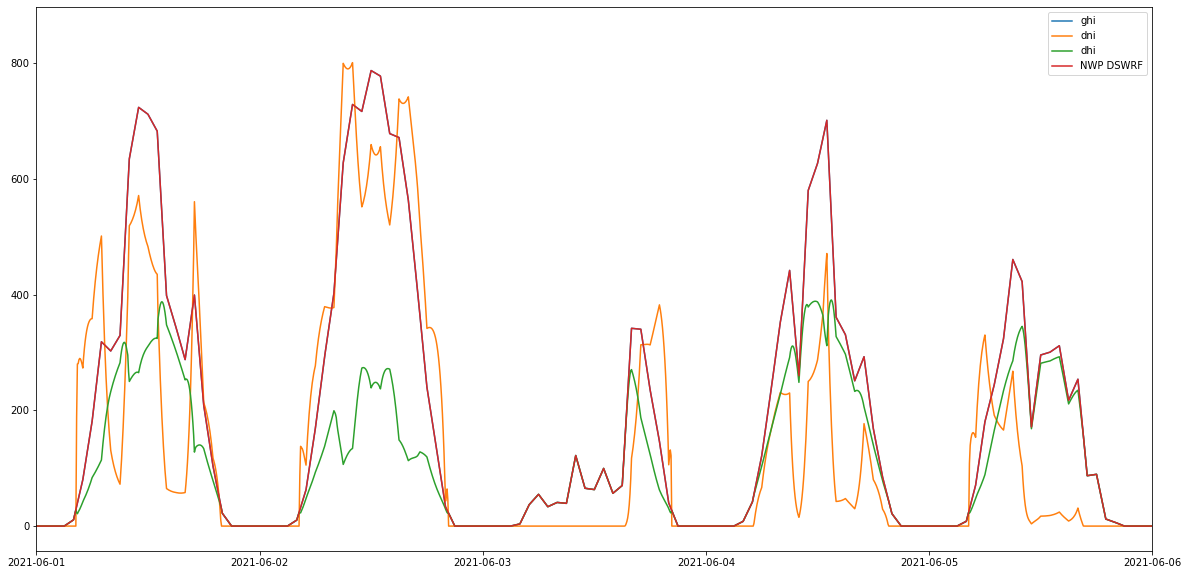

In [36]:
fig, ax = plt.subplots()

ax.plot(irradiance, label=irradiance.columns)
ax.plot(nwp_df["dswrf"], label="NWP DSWRF")
ax.legend()
ax.set_xlim(
    mdates.datestr2num("2021-06-01"),
    mdates.datestr2num("2021-06-06")
)

In [37]:
# NEXT STEPS:
# Produce PV power forecasts using pvlib. Compare using ghi = nwp_df["dswrf"] vs ghi = (OFFSET... etc.
# on the effect it has on the power forecast.

def kelvin_to_celsius(kelvin: pd.Series) -> pd.Series:
    ABSOLUTE_ZERO = -273.15
    return kelvin + ABSOLUTE_ZERO


weather = pd.concat(
    (
        irradiance,
        pd.DataFrame(
            {
                "temp_air": kelvin_to_celsius(nwp_df["t"]),
                "wind_speed": nwp_df["si10"],
            }
        ).resample("5T").interpolate(method="linear", limit=12)
    ),
    axis="columns"
)

model_chain.run_model(weather=weather)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: pvwatts_dc
  ac_model: pvwatts_inverter
  aoi_model: no_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [38]:
weather

,ghi,dni,dhi,temp_air,wind_speed
target_time,,,,,
2021-06-01 00:00:00,0.0,0.0,0.0,13.420013,8.150
2021-06-01 00:05:00,0.0,0.0,0.0,13.445010,8.150
2021-06-01 00:10:00,0.0,0.0,0.0,13.470006,8.150
2021-06-01 00:15:00,0.0,0.0,0.0,13.495003,8.150
2021-06-01 00:20:00,0.0,0.0,0.0,13.520000,8.150
...,...,...,...,...,...
2021-07-01 02:40:00,0.0,0.0,0.0,13.923329,2.950
2021-07-01 02:45:00,0.0,0.0,0.0,13.908745,2.925
2021-07-01 02:50:00,0.0,0.0,0.0,13.894160,2.900


Text(0, 0.5, 'power (Watts)')

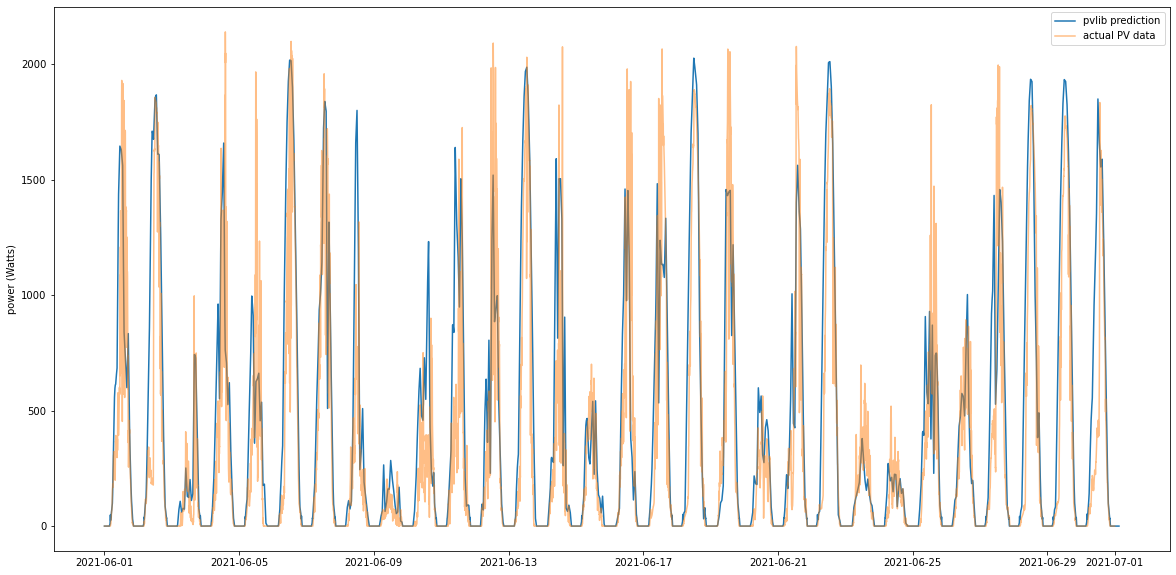

In [39]:
fig, ax = plt.subplots()

ax.plot(model_chain.results.ac, label="pvlib prediction")
ax.plot(pv_data_to_forecast, label="actual PV data", alpha=0.5)
ax.legend()
ax.set_ylabel("power (Watts)")

In [40]:
error = model_chain.results.ac - pv_data_to_forecast
error = error[solpos.elevation > 10]
mean_abs_error = error.abs().mean()
mean_abs_error / power_watts

0.12522614846145091

## Find the NWP grid boxes in the path of the sunlight (using Xiaolin Wu's line algorithm)

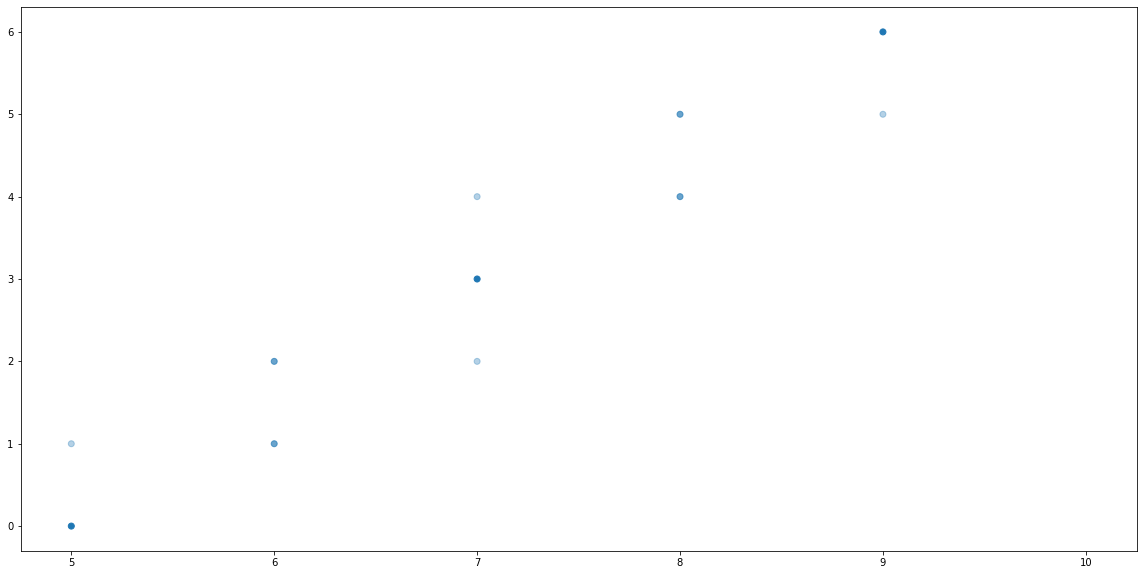

In [72]:
def swap(a, b):
    return b, a


def fractional_part(x: float) -> float:
    return x - np.floor(x)


def draw_line(x0: int, y0: int, x1: int, y1: int) -> tuple[np.ndarray, np.array]:
    """Rasterise a line vector from point (x0, y0) to (x1, y1).
    
    Includes anti-aliasing.
    
    Adapts Xiaolin Wu's line algorithm:
    https://en.wikipedia.org/wiki/Xiaolin_Wu%27s_line_algorithm
    
    To quote Wikipedia:
        The algorithm consists of drawing pairs of pixels straddling the line,
        each coloured according to its distance from the line. Pixels at the
        line ends are handled separately. Lines less than one pixel long
        are handled as a special case.

    Args:
        x0, y0: The start of the line.
        x1, y1: The end of the line.

    Returns: points, alphas
        points: An n x 2 integer matrix. The 2 columns are x and y, the
        integer indicies of the point. n is the number of points.
        The points are ordered from the start of the line
        to the end of the line. The number of points will always be even.
        
        alphas: A n-dimensional floating point vector. The "brightness". In the range [0, 1].
        If the line perfectly fits (without needing any anti-aliasing) then half
        the pairs of pixels will have alpha values of 0.
    """
    for input_arg in (x0, y0, x1, x1):
        assert input_arg >= 0
        assert np.isclose(fractional_part(input_arg), 0)  # Check the input is an int.

    steep: bool = abs(y1 - y0) > abs(x1 - x0)
    
    if steep:
        x0, y0 = swap(x0, y0)
        x1, y1 = swap(x1, y1)

    if x0 > x1:
        x0, x1 = swap(x0, x1)
        y0, y1 = swap(y0, y1)
    
    dx = x1 - x0
    dy = y1 - y0

    if np.isclose(dx, 0):
        gradient = 1.0
    else:
        gradient = dy / dx

    # Handle the start of the line.
    x_end = round(x0)
    y_end = y0 + gradient * (x_end - x0)
    x_gap = 1 - fractional_part(x0 + 0.5)
    x_pixel_1 = x_end  # This will be used in the main loop.
    y_pixel_1 = np.floor(y_end)
    points = []
    if steep:
        points.append((y_pixel_1,   x_pixel_1, 1 - fractional_part(y_end) * x_gap))
        points.append((y_pixel_1 + 1, x_pixel_1, fractional_part(y_end) * x_gap))
    else:
        points.append((x_pixel_1, y_pixel_1  , 1 - fractional_part(y_end) * x_gap))
        points.append((x_pixel_1, y_pixel_1 + 1, fractional_part(y_end) * x_gap))

    y_intersection = y_end + gradient  # First y-intersection for the main loop.
    
    # Handle the end of the line.
    x_end = round(x1)
    y_end = y1 + gradient * (x_end - x1)
    x_gap = fractional_part(x1 + 0.5)
    x_pixel_2 = x_end  # This will be used in the main loop.
    y_pixel_2 = np.floor(y_end)
    if steep:
        last_point_1 = (y_pixel_2  , x_pixel_2, 1 - fractional_part(y_end) * x_gap)
        last_point_2 = (y_pixel_2 + 1, x_pixel_2, fractional_part(y_end) * x_gap)
    else:
        last_point_1 = (x_pixel_2, y_pixel_2,  1 - fractional_part(y_end) * x_gap)
        last_point_2 = (x_pixel_2, y_pixel_2 + 1,fractional_part(y_end) * x_gap)
    
    # Main loop.
    if steep:
        for x in range(x_pixel_1 + 1, x_pixel_2):
            points.append((np.floor(y_intersection), x, 1 - fractional_part(y_intersection)))
            points.append((np.floor(y_intersection) + 1, x, fractional_part(y_intersection)))
            y_intersection = y_intersection + gradient
    else:
        for x in range(x_pixel_1 + 1, x_pixel_2):
            points.append((x, np.floor(y_intersection),  1 - fractional_part(y_intersection)))
            points.append((x, np.floor(y_intersection) + 1, fractional_part(y_intersection)))
            y_intersection = y_intersection + gradient

    # Save the last points.
    points.append(last_point_1)
    points.append(last_point_2)

    points = np.array(points)
    
    # Split into points and alphas, so points can always be ints.
    alphas = points[:, 2].astype(float)
    points = points[:, :2].astype(int)
    
    return points, alphas


points, alphas = draw_line(
    x0=9, y0=6, 
    x1=5, y1=0)

plt.scatter(
    x=points[:, 0],
    y=points[:, 1],
    alpha=alphas,
);

For each timestep:

1. 

In [73]:
solpos

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
target_time,,,,,,
2021-06-01 00:00:00,102.055572,102.055572,-12.055572,-12.055572,355.915873,2.208466
2021-06-01 00:05:00,102.097886,102.097886,-12.097886,-12.097886,357.099707,2.207940
2021-06-01 00:10:00,102.125702,102.125702,-12.125702,-12.125702,358.284141,2.207413
2021-06-01 00:15:00,102.139003,102.139003,-12.139003,-12.139003,359.468926,2.206886
2021-06-01 00:20:00,102.137780,102.137780,-12.137780,-12.137780,0.653811,2.206360
...,...,...,...,...,...,...
2021-07-01 02:40:00,95.924336,95.924336,-5.924336,-5.924336,31.299676,-3.838517
2021-07-01 02:45:00,95.553953,95.553953,-5.553953,-5.553953,32.393505,-3.839186
2021-07-01 02:50:00,95.172271,95.172271,-5.172271,-5.172271,33.482710,-3.839855


<AxesSubplot:xlabel='target_time'>

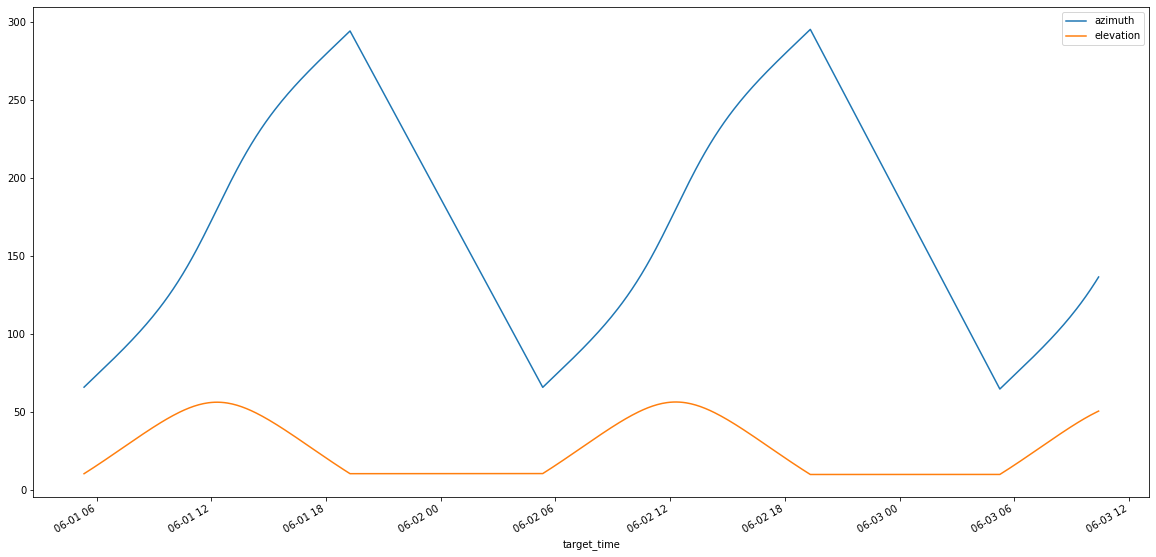

In [85]:
solpos[["azimuth", "elevation"]][solpos["elevation"] > 10].iloc[:400].plot()

In [126]:
def degrees_to_radians(degrees):
    return (degrees / 360) * 2 * np.pi


def dx_and_dy_from_solar_position(
    elevation_degrees: float, 
    azimuth_degrees: float,
    altitude_km: float = 10,
    km_per_nwp_pixel: float = 2,
) -> tuple[int, int]:
    """The Sun's rays pass through a line (in the horizontal plan) starting at (x0, y0) and
    ending at (x0 + dx, y0 + dy). A positive dx moves east. A positive dy moves south.

    Args:
        elevation_degrees (float): The Sun's elevation above the horizon in degrees (90 is directly over head). Must be in the range (0, 90)
        azimuth_degrees (float): The compass direction of the Sun in degrees. 0 is north. 180 is south. Must be in the range (0, 360)
        altitude_km (float, optional): The depth of the atmospheric layer of interest. Defaults to 10 because
            the troposphere is approximately 10 km deep, and almost all clouds exist in the troposphere.
        km_per_nwp_pixel (float, optional): Defaults to 2.

    Returns:
        tuple[float, float]: dx, dy
    """
    assert 0 < azimuth_degrees < 360
    assert 0 < elevation_degrees < 90
    
    azimuth_radians = degrees_to_radians(azimuth_degrees)
    elevation_radians = degrees_to_radians(elevation_degrees)
    
    # Calculate the distance (across the horizontal plane) that the sunlight
    # travels from when it hits `altitude_km` to when it hits the Earth's surface.
    distance_km = np.tan(np.pi / 2 - elevation_radians) * altitude_km
    distance_pixels = distance_km / km_per_nwp_pixel
    
    dx = round(distance_pixels * np.sin(azimuth_radians))
    dy = round(-distance_pixels * np.cos(azimuth_radians))
    
    print(elevation_degrees, azimuth_degrees, distance_pixels, dx, dy)
    return dx, dy


x0 = np.searchsorted(nwp.x.values, pv_x_location_osgb) - 1
y0 = np.searchsorted(nwp.y.values, pv_y_location_osgb) - 1

for datetime in pv_data_to_forecast.index[range(50, 150, 50)]:
    solar_position = solpos.loc[datetime]
    if solar_position.elevation > 10:
        dx, dy = dx_and_dy_from_solar_position(solar_position.elevation, solar_position.azimuth)
        x1 = x0 + dx
        y1 = y0 + dy
        points, alphas = draw_line(x0=x0, y0=y0, x1=x1, y1=y1)
        
        # Mask points and alphas, in case the line goes outside the bounds of the NWP:
        mask = (points[:, 0] < len(nwp.x)) & (points[:, 1] < len(nwp.y))
        points = points[mask]
        alphas = alphas[mask]
        print(points)
        print()
        

35.22734428446501 102.69928556852904 7.080775152007135 7 2
[[229 703]
 [230 703]
 [231 703]
 [232 703]]



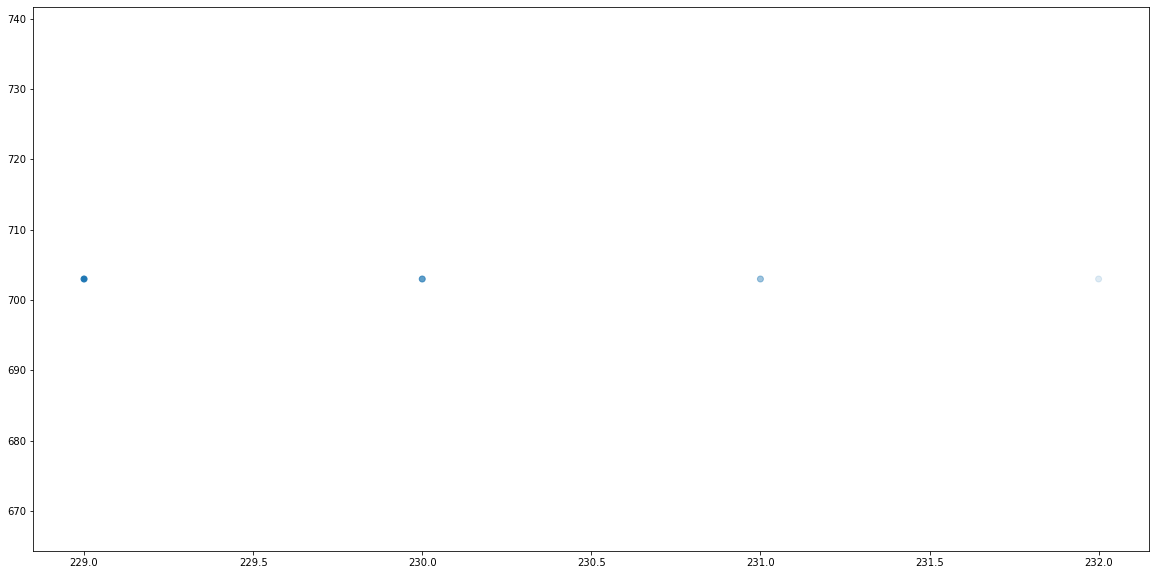

In [127]:

plt.scatter(*points.T, alpha=alphas)

In [128]:
points, alphas

(array([[229, 703],
        [230, 703],
        [231, 703],
        [232, 703]]),
 array([1.        , 0.71428571, 0.42857143, 0.14285714]))

In [129]:
nwp.isel(
    x=points[:, 0],
    y=points[:, 1]
)

<xarray.Dataset>
Dimensions:    (variable: 17, init_time: 5319, step: 37, y: 4, x: 4)
Coordinates:
  * init_time  (init_time) datetime64[ns] 2020-01-01 ... 2021-11-08T15:00:00
  * step       (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * variable   (variable) <U6 'cdcb' 'lcc' 'mcc' ... 'wdir10' 'prmsl' 'prate'
  * x          (x) int64 219000 221000 223000 225000
  * y          (y) int64 -183000 -183000 -183000 -183000
Data variables:
    UKV        (variable, init_time, step, y, x) float32 ...

In [113]:
points[:, 0]

array([229, 229, 230, 230, 231, 231, 232, 232])

In [114]:
points

array([[229, 703],
       [229, 704],
       [230, 703],
       [230, 704],
       [231, 703],
       [231, 704],
       [232, 703],
       [232, 704]])

Next steps:

* Divide the line into 3 segments. Handle the case if the line is less than 3 points long.
* For the segment nearest the PV system, loop through the points in that segment, and compute the sum of the lcc across all those NWP boxes. Then clip the sum at 1.
* Do the same for the middle segment (mcc) and last segment (hcc).
* Use this to compute PV using pvlib
* Then use this as the input to a boosted regression tree (which could also take more summary stats across lcc, mcc, and hcc.)